In [4]:
from pptx import Presentation
import glob
import re
import nltk,string
from nltk import pos_tag , WordNetLemmatizer ,SnowballStemmer
from gensim.models import Word2Vec 
import gensim
import random
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [5]:
slide_text=[];
for eachfile in glob.glob(".\Data\ITM\*.pptx"):
    prs = Presentation(eachfile)
    for slide in prs.slides:
        for shape in slide.shapes:
            if hasattr(shape, "text"):
                for i in shape.text_frame.paragraphs:
                        for j in i.runs:
                            if j.text != '': slide_text.append(j.text.split())

In [6]:
def remove_noise(tweet_tokens,stop_words):
    cleaned_tokens = [];slide_token=[];
    for token, tag in pos_tag(tweet_tokens):
        token = re.sub("[^a-zA-z]","", token)
        
        if len(token)<=1 : token='' 
        
        if tag.startswith("NN"): 
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'
        
        lemmatizer = WordNetLemmatizer()      
        token = lemmatizer.lemmatize(token, pos)
           
        if len(token) > 0 and token not in string.punctuation and token.lower():
            slide_token.append(token.lower())
            
        if len(token) > 0 and token not in string.punctuation and token.lower() not in stop_words:
            cleaned_tokens.append(token.lower())
             
    return cleaned_tokens,slide_token

In [7]:
clean_word2vec=[];clean_doc=[]
for i in slide_text:
    token=remove_noise(i,nltk.corpus.stopwords.words('english'))
    doc_token=token[1]; word2vec_token=token[0];
    if len(word2vec_token) > 0: clean_word2vec.append(word2vec_token)
    if len(doc_token) > 0: clean_doc.append(doc_token)

In [8]:
print("sent ",slide_text[0])
print("word2vec ",clean_word2vec[0])
print("doc2vec ",clean_doc[0])

sent  ['©', '2007', 'Prentice', 'Hall,', 'Inc.']
word2vec  ['prentice', 'hall', 'inc']
doc2vec  ['prentice', 'hall', 'inc']


In [56]:
import multiprocessing
num_features = 300
min_word_count = 3
num_workers = multiprocessing.cpu_count()
context_size = 7
seed = 1

In [57]:
word2vec=None
word2vec = Word2Vec(sg=1,seed=seed,workers=num_workers, size=num_features, 
                                        min_count=min_word_count, window=context_size)

In [58]:
word2vec.build_vocab(sentences=clean_word2vec)
for i in range(5): word2vec.train(sentences=clean_word2vec,epochs=50,total_examples=word2vec.corpus_count)

In [59]:
word2vec.save("model.w2v")
word2vec.wv.most_similar('explain')[:1]

[('studies', 0.526534914970398)]

In [60]:
model=Word2Vec.load("model.w2v")

In [61]:
model.wv.most_similar('explain')[:1]

[('studies', 0.526534914970398)]

# Doc2vec 

In [9]:
clean_doc2vec=[]
for i in enumerate(slide_text):
    clean_doc2vec.append(gensim.models.doc2vec.TaggedDocument(i[1],"tag_"+str(i[0])))

In [10]:
max_epochs = 5;vec_size = 20;alpha = 0.025
doc2vec = Doc2Vec(vector_size=vec_size,alpha=alpha, min_alpha=0.00025,min_count=1,dm =1)

In [11]:
doc2vec.build_vocab(clean_doc2vec)
for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    doc2vec.train(clean_doc2vec,total_examples=doc2vec.corpus_count,epochs=doc2vec.iter)
    doc2vec.alpha -= 0.0002
    doc2vec.min_alpha = doc2vec.alpha

doc2vec.save("d2v.model")
print("Model Saved")

iteration 0


C:\Users\Hamza\anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  after removing the cwd from sys.path.


iteration 1
iteration 2
iteration 3
iteration 4
Model Saved


In [20]:
model.wv.most_similar('managerial')

[('marchapril', 0.6924648284912109),
 ('competencies', 0.6902240514755249),
 ('site', 0.6634171605110168),
 ('web', 0.6494512557983398),
 ('interpersonal', 0.6316547989845276),
 ('find', 0.6259588003158569),
 ('ama', 0.6175143122673035),
 ('conceptual', 0.6166692972183228),
 ('survey', 0.6149014234542847),
 ('american', 0.5683767199516296)]

In [21]:
model

C:\Users\Hamza\anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


IndexError: index 100 is out of bounds for axis 0 with size 100

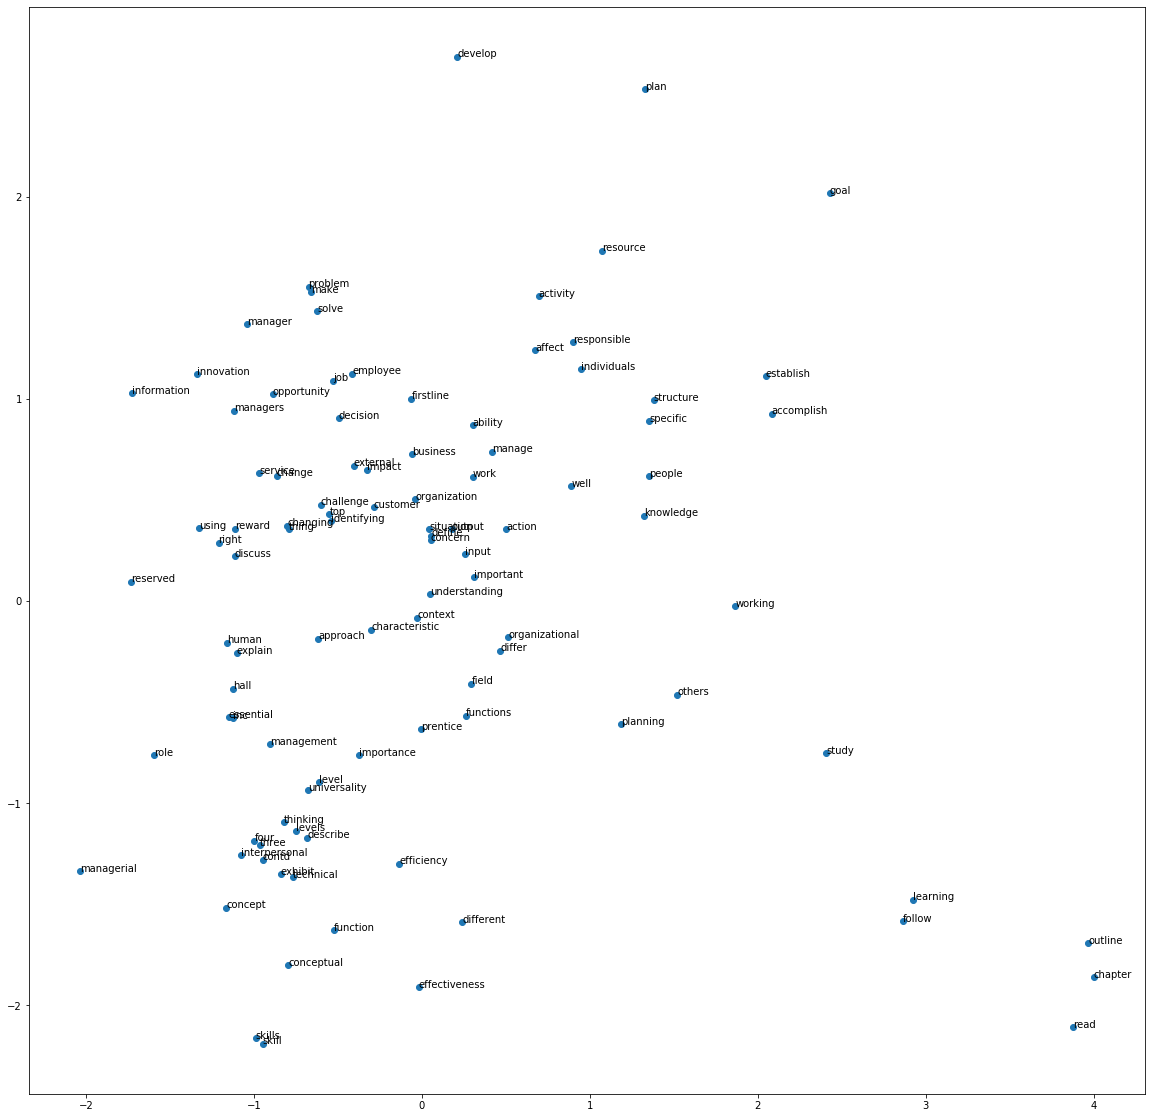

In [34]:
from sklearn.decomposition import PCA
from matplotlib import pyplot
X = model[model.wv.vocab]

pca = PCA(n_components=2)

result = pca.fit_transform(X)
pyplot.figure(figsize=(20,20))
pyplot.scatter(result[:, 0], result[:, 1])

words = list(model.wv.vocab)
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
    
pyplot.show()